We start by importing the calls for basic functions we use with the modeling. Numpy is for controlling data and matplotlib is for graphics

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Next we will import the model and the odesolver from pysb

In [1]:
from pysb.examples.robertson import model
from pysb.integrate import odesolve
import pysb

We will integrate the model for 40 seconds.

In [4]:
t = np.linspace(0, 40,100)
obs_names = ['A_total', 'C_total']

Here we setup the ode solver. We pass it the model, time, and any extra arguments.

In [5]:
solver = pysb.integrate.Solver(model, t, integrator='vode',rtol=1e-8, atol=1e-8)

In [6]:
solver.run()

In [7]:
def normalize(trajectories):
    """Rescale a matrix of model trajectories to 0-1"""
    ymin = trajectories.min(0)
    ymax = trajectories.max(0)
    return (trajectories - ymin) / (ymax - ymin)


def extract_records(recarray, names):
    """Convert a record-type array and list of names into a float array"""
    return np.vstack([recarray[name] for name in names]).T

In [8]:
ysim_array = extract_records(solver.yobs, obs_names)
norm_data = normalize(ysim_array)

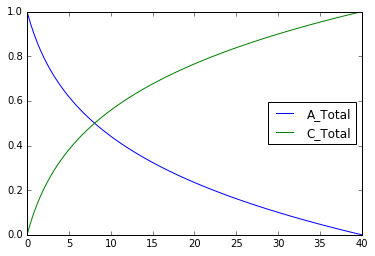

In [9]:
plt.plot(t,norm_data)
plt.legend(['A_Total','C_Total'], loc = 0)

We are going to make some noisy data for optimization.

In [10]:
noisy_data_A = ysim_array[:,0] + np.random.uniform(-0.02,0.02,np.shape(ysim_array[:,0]))
norm_noisy_data_A = normalize(noisy_data_A)
noisy_data_C = ysim_array[:,1] + np.random.uniform(-.02,.01,np.shape(ysim_array[:,1]))
norm_noisy_data_C = normalize(noisy_data_C)
ydata_norm = np.column_stack((norm_noisy_data_A,norm_noisy_data_C))

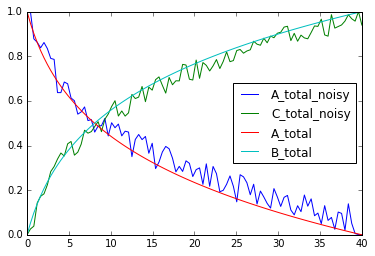

In [11]:
plt.plot(t,norm_noisy_data_A)
plt.plot(t,norm_noisy_data_C)
plt.plot(t,norm_data)
plt.legend(['A_total_noisy','C_total_noisy','A_total', 'B_total', 'C_total'], loc=0)

In [12]:
from pso import PSO

Now we need to define a few things to simply the process.
We want to optimize only the rate parameters, assuming that initial conditions are OK.
We also define bounds, here up and down 1 order of magnitude (in log10 space).

In [13]:
rate_params = model.parameters_rules()
param_values = np.array([p.value for p in model.parameters])
rate_mask = np.array([p in rate_params for p in model.parameters])

nominal_values = np.array([p.value for p in model.parameters])
xnominal = np.log10(nominal_values[rate_mask]) 
bounds_radius = 2
lb = xnominal - bounds_radius
ub = xnominal + bounds_radius

This is just a small function to the same plot over and over again. Power of functions!
Now we can plot the results directly.

In [14]:
def display(x=None):
    if x == None:
        solver.run(param_values)
    else:
        Y=np.copy(x)
        param_values[rate_mask] = 10 ** Y
        solver.run(param_values)
    ysim_array = extract_records(solver.yobs, obs_names)
    ysim_norm = normalize(ysim_array)
    count=1
    plt.figure(figsize=(8,6),dpi=200)
    plt.plot(t,ysim_norm[:,0],label='A')
    plt.plot(t,ysim_norm[:,1],label='C')
    plt.plot(t,norm_noisy_data_A,label='Noisy A')
    plt.plot(t,norm_noisy_data_C,label='Noisy C')
    plt.legend(loc=0)
    plt.ylabel('concentration')
    plt.xlabel('time (s)')
    plt.show()

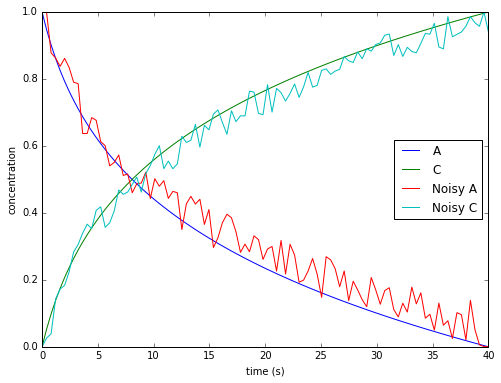

In [15]:
display()

To demonstrate we need to perturb our models parameters.

In [22]:
print xnominal**10
start_position = xnominal +np.random.uniform(-1.0,1.0,size = np.shape(xnominal))
print start_position**10

[  2.85026569e+01   5.46190618e+08   1.04857600e+06]
[  2.82850189e+02   1.90456346e+09   7.81740446e+06]


Now we define an objective function to minimize. Since we don't have experimental data, we will use the synthetic data created above. 

In [23]:
def obj_function(params):
    if np.any((params < lb) | (params> ub)):
        return 1000,
    params_tmp = np.copy(params)
    param_values[rate_mask] = 10 ** params_tmp
    solver.run(param_values)
    ysim_array = extract_records(solver.yobs, obs_names)
    ysim_norm = normalize(ysim_array)
    err = np.sum((ydata_norm - ysim_norm) ** 2 )
    if np.isnan(err):
        return 1000,
    return err,

In [24]:
optimizer = PSO(cost_function=obj_function,start=start_position,verbose=True)

In [25]:
optimizer.set_bounds(parameter_range=1)

In [26]:
optimizer.run(100,100)

Initial cost function value  (0.44233915813044566,)
gen	evals	avg          	std          	min          	max          
1  	100  	[ 1.15383021]	[ 0.77043788]	[ 0.32552685]	[ 3.98931794] (0.32552684973504775,)


2  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
3  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


4  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
5  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


6  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
7  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


8  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
9  	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


10 	100  	[ 3.04592438]	[ 2.0856205] 	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
11 	100  	[ 3.03935697]	[ 2.08779937]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


12 	100  	[ 3.038632]  	[ 2.08845047]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
13 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


14 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
15 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


16 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
17 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


18 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
19 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


20 	100  	[ 3.03103418]	[ 2.09675526]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)
21 	100  	[ 3.03109879]	[ 2.09667329]	[ 0.36762221]	[ 6.10627331] (0.32552684973504775,)


22 	100  	[ 3.03086971]	[ 2.09700269]	[ 0.3239142] 	[ 6.10627331] (0.32391419895138407,)
23 	100  	[ 3.0325418] 	[ 2.09525431]	[ 0.35800681]	[ 6.10627331] (0.32391419895138407,)


24 	100  	[ 3.03090171]	[ 2.0973182] 	[ 0.32794855]	[ 6.10627331] (0.32391419895138407,)
25 	100  	[ 3.0309393] 	[ 2.09726999]	[ 0.32767529]	[ 6.10627331] (0.32391419895138407,)


26 	100  	[ 3.02435022]	[ 2.08881539]	[ 0.33156429]	[ 6.10627331] (0.32391419895138407,)
27 	100  	[ 3.01654884]	[ 2.07925451]	[ 0.32400036]	[ 6.10627331] (0.32391419895138407,)


28 	100  	[ 2.97504373]	[ 2.05882841]	[ 0.32808993]	[ 6.10627331] (0.32391419895138407,)
29 	100  	[ 2.95098839]	[ 2.08298462]	[ 0.32405764]	[ 6.10627331] (0.32391419895138407,)


30 	100  	[ 2.89111519]	[ 2.08639237]	[ 0.3241424] 	[ 6.10627331] (0.32391419895138407,)
31 	100  	[ 2.88033661]	[ 2.14975271]	[ 0.32406988]	[ 6.10627331] (0.32391419895138407,)


32 	100  	[ 2.81992062]	[ 2.17900715]	[ 0.32391542]	[ 6.10627331] (0.32391419895138407,)
33 	100  	[ 2.54913234]	[ 2.01638048]	[ 0.32406303]	[ 6.10627331] (0.32391419895138407,)


34 	100  	[ 2.24645098]	[ 2.03762169]	[ 0.32418625]	[ 6.10627331] (0.32391419895138407,)
35 	100  	[ 2.08484547]	[ 1.98665325]	[ 0.32404961]	[ 6.10627331] (0.32391419895138407,)


36 	100  	[ 1.56657974]	[ 1.60509186]	[ 0.32417399]	[ 6.10627331] (0.32391419895138407,)
37 	100  	[ 0.98753918]	[ 1.00507878]	[ 0.32460283]	[ 5.41088553] (0.32391419895138407,)


38 	100  	[ 0.74928302]	[ 1.0049566] 	[ 0.32395451]	[ 5.91062757] (0.32391419895138407,)
39 	100  	[ 0.53546175]	[ 0.43340807]	[ 0.32393938]	[ 3.6288194]  (0.32391419895138407,)


40 	100  	[ 0.49504]   	[ 0.4777804] 	[ 0.32389671]	[ 4.22464771] (0.32389670805884174,)
41 	100  	[ 0.48839843]	[ 0.44295158]	[ 0.32395016]	[ 3.5693225]  (0.32389670805884174,)


42 	100  	[ 0.46164262]	[ 0.59235668]	[ 0.32389744]	[ 6.08917396] (0.32389670805884174,)
43 	100  	[ 0.42482045]	[ 0.51387543]	[ 0.32381296]	[ 5.34865905] (0.32381295707825009,)


44 	100  	[ 0.42100973]	[ 0.36658949]	[ 0.32384479]	[ 3.3233977]  (0.32381295707825009,)
45 	100  	[ 0.40316024]	[ 0.31125583]	[ 0.32387537]	[ 2.89334897] (0.32381295707825009,)


46 	100  	[ 0.39756967]	[ 0.29758757]	[ 0.32388082]	[ 2.61636365] (0.32381295707825009,)
47 	100  	[ 0.35690735]	[ 0.12139347]	[ 0.32387065]	[ 1.11612226] (0.32381295707825009,)


48 	100  	[ 0.34947871]	[ 0.09867943]	[ 0.32387857]	[ 0.9679725]  (0.32381295707825009,)
49 	100  	[ 0.34621477]	[ 0.09041375]	[ 0.32361651]	[ 1.04948544] (0.32361651142170111,)


50 	100  	[ 0.36288183]	[ 0.22230439]	[ 0.32384924]	[ 2.42342211] (0.32361651142170111,)
51 	100  	[ 0.34785745]	[ 0.17203835]	[ 0.32351006]	[ 2.02450376] (0.32351006262416271,)


52 	100  	[ 0.34707819]	[ 0.11233413]	[ 0.3238591] 	[ 1.22666225] (0.32351006262416271,)
53 	100  	[ 0.34923723]	[ 0.10716506]	[ 0.32377064]	[ 1.02125457] (0.32351006262416271,)


54 	100  	[ 0.33298014]	[ 0.06044077]	[ 0.32386676]	[ 0.91931703] (0.32351006262416271,)
55 	100  	[ 0.33109462]	[ 0.03457064]	[ 0.32337348]	[ 0.59695846] (0.32337348122871212,)


56 	100  	[ 0.32814892]	[ 0.02531268]	[ 0.32372545]	[ 0.56858814] (0.32337348122871212,)
57 	100  	[ 0.33475912]	[ 0.08932034]	[ 0.32349507]	[ 1.21695493] (0.32337348122871212,)


58 	100  	[ 0.3288443] 	[ 0.02367147]	[ 0.32336814]	[ 0.51077889] (0.32336814282367821,)
59 	100  	[ 0.32542897]	[ 0.01004881]	[ 0.32361685]	[ 0.42092612] (0.32336814282367821,)


60 	100  	[ 0.3329055] 	[ 0.05101097]	[ 0.32365709]	[ 0.75827818] (0.32336814282367821,)
61 	100  	[ 0.32906242]	[ 0.02404749]	[ 0.32349098]	[ 0.50004771] (0.32336814282367821,)


62 	100  	[ 0.32656233]	[ 0.01207513]	[ 0.32338958]	[ 0.41165976] (0.32336814282367821,)
63 	100  	[ 0.32909241]	[ 0.02611263]	[ 0.32341369]	[ 0.56281056] (0.32336814282367821,)


64 	100  	[ 0.32861758]	[ 0.02494531]	[ 0.32333371]	[ 0.53381799] (0.32333371124418142,)
65 	100  	[ 0.32987513]	[ 0.04153487]	[ 0.32347568]	[ 0.72923642] (0.32333371124418142,)


66 	100  	[ 0.32539165]	[ 0.00606698]	[ 0.32332457]	[ 0.36060562] (0.32332457495812555,)
67 	100  	[ 0.32492565]	[ 0.00430201]	[ 0.32333346]	[ 0.34945159] (0.32332457495812555,)


68 	100  	[ 0.32440597]	[ 0.0030831] 	[ 0.32333139]	[ 0.34884691] (0.32332457495812555,)
69 	100  	[ 0.32689652]	[ 0.02736146]	[ 0.32336584]	[ 0.5987309]  (0.32332457495812555,)


70 	100  	[ 0.32602306]	[ 0.01439246]	[ 0.32332494]	[ 0.43999451] (0.32332457495812555,)
71 	100  	[ 0.3249867] 	[ 0.00810351]	[ 0.32329198]	[ 0.40393773] (0.32329197521292941,)


72 	100  	[ 0.32426297]	[ 0.00252058]	[ 0.32332535]	[ 0.34814185] (0.32329197521292941,)
73 	100  	[ 0.32488829]	[ 0.00915377]	[ 0.32332384]	[ 0.41576515] (0.32329197521292941,)


74 	100  	[ 0.32460292]	[ 0.00594328]	[ 0.32332874]	[ 0.38320692] (0.32329197521292941,)
75 	100  	[ 0.32433177]	[ 0.00294997]	[ 0.32333225]	[ 0.35208652] (0.32329197521292941,)


76 	100  	[ 0.32437122]	[ 0.00330779]	[ 0.32332548]	[ 0.34993321] (0.32329197521292941,)
77 	100  	[ 0.32444748]	[ 0.00456777]	[ 0.32332351]	[ 0.36833287] (0.32329197521292941,)


78 	100  	[ 0.32404605]	[ 0.0013088] 	[ 0.32332934]	[ 0.33612611] (0.32329197521292941,)
79 	100  	[ 0.3239924] 	[ 0.00080749]	[ 0.32333611]	[ 0.3299492]  (0.32329197521292941,)


80 	100  	[ 0.32398121]	[ 0.00069412]	[ 0.32333615]	[ 0.33021153] (0.32329197521292941,)
81 	100  	[ 0.3240362] 	[ 0.00114315]	[ 0.32333639]	[ 0.33438458] (0.32329197521292941,)


82 	100  	[ 0.32418008]	[ 0.00256644]	[ 0.32332967]	[ 0.34939822] (0.32329197521292941,)
83 	100  	[ 0.32394299]	[ 0.00059795]	[ 0.32332543]	[ 0.32932624] (0.32329197521292941,)


84 	100  	[ 0.32407793]	[ 0.00167251]	[ 0.32329351]	[ 0.33985958] (0.32329197521292941,)
85 	100  	[ 0.32398622]	[ 0.00099101]	[ 0.32332459]	[ 0.33324744] (0.32329197521292941,)


86 	100  	[ 0.32401719]	[ 0.00106494]	[ 0.32332526]	[ 0.33251968] (0.32329197521292941,)
87 	100  	[ 0.32403532]	[ 0.00105143]	[ 0.32329349]	[ 0.33245129] (0.32329197521292941,)


88 	100  	[ 0.32418331]	[ 0.00245984]	[ 0.32332167]	[ 0.34780371] (0.32329197521292941,)
89 	100  	[ 0.32402034]	[ 0.00142245]	[ 0.3233298] 	[ 0.33798208] (0.32329197521292941,)


90 	100  	[ 0.3240326] 	[ 0.00158566]	[ 0.32332527]	[ 0.33965885] (0.32329197521292941,)
91 	100  	[ 0.32394236]	[ 0.00077033]	[ 0.32329448]	[ 0.33134741] (0.32329197521292941,)


92 	100  	[ 0.32393794]	[ 0.00066933]	[ 0.32332466]	[ 0.33024763] (0.32329197521292941,)
93 	100  	[ 0.32396627]	[ 0.00100603]	[ 0.32329478]	[ 0.33379028] (0.32329197521292941,)


94 	100  	[ 0.3239731] 	[ 0.00102826]	[ 0.32331614]	[ 0.33396909] (0.32329197521292941,)
95 	100  	[ 0.32392953]	[ 0.00058451]	[ 0.32332564]	[ 0.32924231] (0.32329197521292941,)


96 	100  	[ 0.32392711]	[ 0.00043983]	[ 0.32332544]	[ 0.32676823] (0.32329197521292941,)
97 	100  	[ 0.32390134]	[ 0.00028714]	[ 0.32332537]	[ 0.3255606]  (0.32329197521292941,)


98 	100  	[ 0.32390056]	[ 0.00030265]	[ 0.32333251]	[ 0.32567951] (0.32329197521292941,)
99 	100  	[ 0.32389053]	[ 0.00023802]	[ 0.32332833]	[ 0.32520795] (0.32329197521292941,)


100	100  	[ 0.32388449]	[ 0.00023722]	[ 0.32332295]	[ 0.32511197] (0.32329197521292941,)


(array([ 0.32552685,  0.32552685,  0.32552685,  0.32552685,  0.32552685,
         0.32552685,  0.32552685,  0.32552685,  0.32552685,  0.32552685,
         0.32552685,  0.32552685,  0.32552685,  0.32552685,  0.32552685,
         0.32552685,  0.32552685,  0.32552685,  0.32552685,  0.32552685,
         0.32552685,  0.3239142 ,  0.3239142 ,  0.3239142 ,  0.3239142 ,
         0.3239142 ,  0.3239142 ,  0.3239142 ,  0.3239142 ,  0.3239142 ,
         0.3239142 ,  0.3239142 ,  0.3239142 ,  0.3239142 ,  0.3239142 ,
         0.3239142 ,  0.3239142 ,  0.3239142 ,  0.3239142 ,  0.32389671,
         0.32389671,  0.32389671,  0.32381296,  0.32381296,  0.32381296,
         0.32381296,  0.32381296,  0.32381296,  0.32361651,  0.32361651,
         0.32351006,  0.32351006,  0.32351006,  0.32351006,  0.32337348,
         0.32337348,  0.32337348,  0.32336814,  0.32336814,  0.32336814,
         0.32336814,  0.32336814,  0.32336814,  0.32333371,  0.32333371,
         0.32332457,  0.32332457,  0.32332457,  0.3

Now to view our initial parameters compared to the optimized parameters!

/home/pinojc/Virtual_envs/pso_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


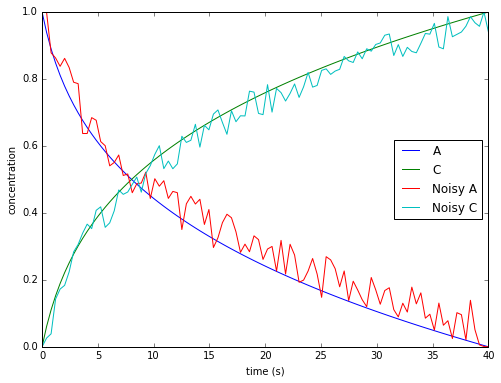

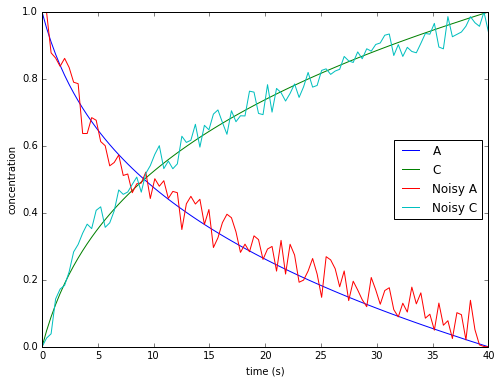

In [29]:
display(start_position)
display(optimizer.best)

In [28]:
print(optimizer.best)
print(xnominal)

[-2.75855375  9.47187511  5.72558074]
[-1.39794001  7.47712125  4.        ]
